# Pulse wave classification in 7 classes（Undergraduate Design）
2022.4.10  author: Loki Xun

---
## 数据预处理
- 统一采样率
- 分片

## 时域：波形时序数据分类
- Bi-Lstm
- Transformer

## 频域：提取 MFCC、Fbank 特征
- 使用 CNN 分类

## 特征融合：Two-stream CNN 方式




In [ ]:
from google.colab import drive #挂载云端硬盘
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 查看分配到的 GPU 资源是否为 P100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu May  5 17:24:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=7e51b611ac489c3071aeac00633c2c2b40de0de3cde85a1a077c3f67768ae3e5
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import os
import re
from pathlib import Path
import random
from typing import Tuple, Union, Dict, List
import math
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct
from scipy.signal import spectrogram
from scipy.signal import resample_poly, butter, filtfilt, medfilt
from python_speech_features import mfcc, delta, fbank
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
# 显存设置
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# GPU 设置
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #保证程序中的GPU序号和硬件中的序号相同
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #设置 -1 使用 CPU 训练

# #  TensorFlow程序会默认占用显卡中的所有显存，设置按需求动态增长
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


pulse_class_name_list = ["滑脉", "平脉", "实脉", "细脉", "细弦脉", "弦滑脉", "弦脉"]  # 下标对应 class_no
base_path = Path("/content/drive/MyDrive/Pulse_7_Classification").resolve()
assert os.path.exists(base_path), "base_path loading failed!"
pulse_dataset_dir = base_path.joinpath("seven_pulse2018")
print(f"base_path={base_path}")
feature_result_dir = base_path.joinpath("feature_result")

base_path=/content/drive/MyDrive/Pulse_7_Classification


# 数据预处理
## data_preprocessing.py 数据预处理、频域特征提取

In [ ]:
class PulsePreprocessing:
    def __init__(self):
        self._test_num_each_class = 5

    @staticmethod
    def detrend_sigle_wave_data(wave_data_array, current_sample_rate=666) -> np.ndarray:
        """
        去除基线漂移: 基线漂移是一种低频噪声成分, 频率通常小于1Hz, 使用巴特沃斯高通过滤
        :param wave_data_array:
        :param current_sample_rate:
        :return:
        """
        assert len(wave_data_array.shape) == 2, f"wave_data_array shape={wave_data_array.shape} not match!"
        start_time = time.time()

        #  1. 0.5-50Hz 四阶巴特沃斯带通过滤器
        LOW_CUT = 0.5
        HIGH_CUT = 100
        fn = 0.5 * current_sample_rate  # 最大频率
        f_low = LOW_CUT / fn
        f_high = HIGH_CUT / fn

        method_name = f"{LOW_CUT}Hz-{HIGH_CUT}Hz bandpass"
        freq_window = [f_low, f_high]
        b, a = butter(N=4, Wn=freq_window, btype="bandpass")
        filtered_signal = filtfilt(b, a, wave_data_array)
        # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        # # 2. 1Hz 巴特沃斯高通
        # method_name = f"{LOW_CUT}Hz HighPass"
        # freq_window = f_low
        # b, a = butter(N=4, Wn=freq_window, btype="highpass")
        # filtered_signal = filtfilt(b, a, wave_data_array)
        # # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        return filtered_signal

    @staticmethod
    def get_wave_peak_bottom_index(wave_data_array, current_sample_rate=666):
        # TODO: pip install biosppy
        assert len(wave_data_array.shape) == 2, f"shape not match"
        # peak_result = ecg.christov_segmenter(wave_data_array[0,], sampling_rate=current_sample_rate)
        # rpeaks_result = peak_result['rpeaks']
        # # get bottom
        # peak_result = ecg.christov_segmenter(wave_data_array[0,] * (-1), sampling_rate=current_sample_rate)
        # bottom_result = peak_result['rpeaks']
        # return rpeaks_result, bottom_result

    @staticmethod
    def copy_file_to_another_dir(source_path, save_path) -> Tuple[bool, str]:
        try:
            if not Path(source_path).is_file():
                raise Exception(f"原始文件不存在！source_path={source_path}")

            shutil.copy(source_path, save_path)
            return True, save_path

        except Exception as e:
            state_message = f"转移文件失败！message={str(e)}"
            logger.exception(state_message)
            return False, state_message

    @staticmethod
    def plot_wave_data(origin_pulse_array, downsampled_pulse_array, time_len: int):
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(origin_pulse_array, 'r-')
        plt.title(f"origin freq={origin_pulse_array.shape[0] / time_len} Hz")
        plt.subplot(2, 1, 2)
        plt.plot(downsampled_pulse_array, "b-")
        plt.title(f"downsample freq={downsampled_pulse_array.shape[0] / time_len} Hz")
        plt.grid(which="minor", linestyle='-.', axis='both')
        plt.show()

    @staticmethod
    def save_npy_file(pulse_data_dict, save_filename="train_test_data.npz"):
        save_path = pulse_dataset_dir.joinpath(save_filename).as_posix()
        np.savez(save_path, pulse_data=pulse_data_dict)
        print(f"保存npz 文件成功！save_path={save_path}")

    @staticmethod
    def load_npy_saved_pulse_data(npz_save_path: str) -> Dict[int, Dict[str, List[dict]]]:
        """
        load from npz file
            Pulse data description: In total 988 pulse samples, pulse's time info={'60.0s': 899, '6.0s': 89}: pulse data
           have 2 kinds of times info. And pulse data have sparse pressure info.
        :param npz_save_path:
        :return: pulse data dict-> Dict[ key=class->int, value=Dict[key in ('test','train'), value= signle_data_dict] ]
            single_data_dict=Dict['t':int, 'p':float, 'data':numpy array]
        """
        npz_result = np.load(npz_save_path, allow_pickle=True)
        pulse_all_class_data_dict = npz_result['pulse_data'].item()
        return pulse_all_class_data_dict

    @staticmethod
    def load_one_txt_data(data_filepath: str) -> Tuple[bool, Union[str, dict]]:
        """
        读取 txt 波形数据到 pandas.DataFrame
        :param data_filepath: 读取 txt 文件中数据
        :return: Dict[ 't': 秒数->float, 'p': 压力值->float, "data":时序波形数据->ndarray, 'filepath': str]
        """
        try:
            pulse_wave_data_list = []
            with open(data_filepath, "r+") as fp:
                for line_no, data_str in enumerate(fp.readlines()):
                    data_str = data_str.replace("\n", "")
                    if line_no == 0:
                        t_pulse, p_pulse = re.findall(r"\d+.\d*", data_str)[:2]
                    else:
                        pulse_wave_data_list.append(eval(data_str))

            return True, {"t": t_pulse, "p": p_pulse, "data": np.array([pulse_wave_data_list]),
                          'filepath': Path(data_filepath).name}
        except Exception as e:
            logger.exception(f"load_one_txt_data Failed! data_filepath={data_filepath}")
            return False, str(e)

    def split_origin_train_test_data(self) -> Tuple[bool, Union[dict, str]]:
        """
        分割 train、test 数据，存入字典，保存 npy 文件
        :return: data dict-> Dict[class_label, Dict[test:[], train:[]] ]
        """
        pulse_data_dict = {}
        for class_name in os.listdir(pulse_all_data_path.as_posix()):
            class_label = pulse_class_name_list.index(class_name)
            print(f"class={class_name}, class_label={class_label}")
            if class_name not in pulse_class_name_list:
                raise Exception(f"unsupported class type!class_name={class_name}")

            class_dir_path = pulse_all_data_path.joinpath(class_name)
            class_data_path_list = [class_dir_path.joinpath(item_filename).as_posix()
                                    for item_filename in os.listdir(class_dir_path.as_posix())]
            if not class_data_path_list:
                raise Exception(f"class={class_name} with empty data!")
            # 0. shuffle sequence
            random.seed(1)  # 设置随机种子，使得每次运行结果可复现
            random.shuffle(class_data_path_list)
            # 1. split train test
            test_filename_list = class_data_path_list[:self._test_num_each_class]
            train_filename_list = class_data_path_list[self._test_num_each_class:]

            # 2. extract data
            pulse_data_dict[class_label] = {"train": [], "test": []}
            for data_filepath in test_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["test"].append(data_info_result)

            for data_filepath in train_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["train"].append(data_info_result)

            logger.info(f"class={class_name}, label={class_label}: train_test_split success!"
                        f"train_num={len(train_filename_list)}, test_num={len(test_filename_list)}")
        # save npy file
        self.save_npy_file(pulse_data_dict)
        print(f"train_test_split finish!")
        return True, pulse_data_dict

    @staticmethod
    def downsample_pulse_data(wave_data_array, origin_time_length, target_sample_rate):
        """对数据进行重采样"""
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 2
        # 1. 均匀采样
        time_index_list = np.linspace(start=0, stop=wave_data_array.shape[1],
                                      num=math.ceil(origin_time_length * target_sample_rate), endpoint=False, dtype=int)
        # downsampled_data = wave_data_array[:, time_index_list]
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={wave_data_array.shape}, time_index_list={time_index_list}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        # 1.2 np.interp
        downsampled_data = np.interp(time_index_list, np.arange(0, wave_data_array.shape[1]), wave_data_array[0])
        downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        print(f"wave_data_list={wave_data_array}, shape={wave_data_array.shape}")
        print(f"downsampled_data={downsampled_data}, shape={downsampled_data.shape}")

        # # 2. scipy signal
        # current_sample_rate = int(wave_data_array.shape[1] / origin_time_length)
        # downsampled_data = resample_poly(wave_data_array[0, :], up=target_sample_rate, down=current_sample_rate)
        # downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        return downsampled_data

    def unify_sample_rate(self, pulse_all_class_data_dict, target_sample_rate=666):
        """
        统一sample rate, 全部降采样到 666 Hz （采样率的最小值）
        :param pulse_all_class_data_dict:
        :param target_sample_rate:
        :return:
        """
        for class_no in pulse_all_class_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_class_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_class_data_dict[class_no][type_str][data_index]
                    wave_data_array = data_info_dict['data']
                    down_sample_data = self.downsample_pulse_data(wave_data_array=data_info_dict["data"],
                                                                  origin_time_length=eval(data_info_dict['t']),
                                                                  target_sample_rate=target_sample_rate)
                    pulse_all_class_data_dict[class_no][type_str][data_index]["data"] = down_sample_data
                    # self.plot_wave_data(wave_data_array[0,], down_sample_data[0,], time_len=eval(data_info_dict['t']))

            print(f"class_no={class_no} 降采样完成！")
        return pulse_all_class_data_dict

    @staticmethod
    def get_train_test_data_slice(pulse_all_data_dict, frame_length=600, frame_step=350):
        """
        对原始时序数据按 步长、帧移 分片，获取模型输入 x_train, y_train
        :param pulse_all_data_dict: Dict[class_no->int, key=Dict[key in ('train','test'), value=List[data_info_dict]] ]
            data_info_dict -> Dict['t'->str, 'p'->str, 'data'->np.ndarray(shape=(1,n))]
        :param frame_length:
        :param frame_step:
        :return: x_train->np.ndarray , shape= (n, frame_length), y_train->np.ndarray, shape=(n,1)
        """
        train_data_dict = {"x_train": [], "y_train": [], "x_test": [], "y_test": []}
        # 帧移调整参数，提前求出
        class_frame_step_dict = {6: int(frame_step/0.36), 5: int(frame_step/0.81), 4: int(frame_step/1.2),
                                 3: int(frame_step / 5), 2: int(frame_step / 3), 1: int(frame_step / 4), 0: int(frame_step / 1.7)}
        # class_frame_step_dict = {6: min(frame_length,frame_length-100), 5: frame_step, 4: frame_step,
        #                          3: int(frame_step / 5), 2: int(frame_step / 3), 1: frame_step, 0: frame_step}
        origin_frame_step=frame_step
        for class_no in pulse_all_data_dict:
            for data_type_str in ["train", "test"]:
                # 少数类,增加分片数, 多数类减少分片数
                frame_step = class_frame_step_dict[class_no] if data_type_str=="train" else origin_frame_step

                for data_info_dict in pulse_all_data_dict[class_no][data_type_str]:
                    # 分片
                    wave_data_array = data_info_dict["data"][0,]  # 原始 shape=(1,n)
                    signal_length = len(wave_data_array)
                    num_frames = int(
                        np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
                    pad_signal_length = (num_frames - 1) * frame_step + frame_length
                    z = np.zeros((pad_signal_length - signal_length))
                    # 分帧后最后一帧点数不足，则补零
                    # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
                    pad_signal = np.append(wave_data_array, z)
                    indices = np.arange(0, frame_length).reshape(
                        1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
                    frames = pad_signal[indices]

                    # add to x_train, y_train
                    train_data_dict[f"x_{data_type_str}"].extend(frames.tolist())
                    train_data_dict[f"y_{data_type_str}"].extend([int(class_no)] * frames.shape[0])

                print(f"class_no={class_no}, data_type_str={data_type_str} 分片完成！")

        x_train = np.array(train_data_dict["x_train"])
        y_train = np.array(train_data_dict["y_train"]).reshape((-1, 1))
        x_test = np.array(train_data_dict["x_test"])
        y_test = np.array(train_data_dict["y_test"]).reshape((-1, 1))

        print(f"x_train shape={x_train.shape}")
        print(f"y_train shape={y_train.shape}")
        print(f"x_test shape={x_test.shape}")
        print(f"y_test shape={y_test.shape}")

        return x_train, y_train, x_test, y_test

    def detrend_wave_data(self, pulse_all_data_dict):
        for class_no in pulse_all_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_data_dict[class_no][type_str][data_index]
                    current_sample_rate = int(data_info_dict["data"].shape[1] / eval(data_info_dict['t']))
                    detrend_wave_data = self.detrend_sigle_wave_data(data_info_dict["data"],
                                                                     current_sample_rate=current_sample_rate)
                    pulse_all_data_dict[class_no][type_str][data_index]["data"] = detrend_wave_data

            print(f"class_no={class_no} 去基线漂移完成！")
        return pulse_all_data_dict

    
class PulseFeature:
    def __init__(self):
        pass

    @staticmethod
    def standardize_wave_data(wave_data):
        wave_mean = np.mean(wave_data, axis=1)
        wave_std = np.std(wave_data, axis=1)
        return (wave_data - wave_mean) / wave_std

    @staticmethod
    def plot_spectrogram(spec, save_path):
        fig = plt.figure(figsize=(20, 5))
        heatmap = plt.pcolor(spec)
        fig.colorbar(mappable=heatmap)
        plt.xlabel('Frames')
        # tight_layout 会自动调整子图参数，使之填充整个图像区域
        # plt.tight_layout()
        plt.title(save_path.stem)
        plt.savefig(save_path)
        plt.show()

    @staticmethod
    def get_scipy_spectrogram(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, filename=""):
        freq_array, time_segment, Spectrogram_x = spectrogram(x=wave_data[0, :], fs=sample_rate)
        plt.figure(1)
        plt.pcolormesh(time_segment, freq_array, Spectrogram_x, shading="gouraud")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

    @staticmethod
    def get_frames(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01):
        """
        预加重, 分帧, 幅值归一化
        :param wave_data: ndarray, shape=(1,n)
        :param sample_rate: 采样率
        :param frame_size: 帧长 默认 25 ms
        :param frame_stride: 帧移 默认 10 ms
        :return:
        """
        # 1. 预加重: 补偿高频部分振幅
        pre_emphasis = 0.97
        emphasized_signal = np.append(
            wave_data[0, 0], wave_data[:, 1:] - pre_emphasis * wave_data[:, -1])

        # 2. 分帧
        frame_length, frame_step = int(
            round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
        signal_length = len(emphasized_signal)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(emphasized_signal, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        print("shape of frames:", frames.shape)

        # 3. 加 hamming 窗
        frames *= np.hamming(frame_length)
        return frames

    def save_fbank_mfcc_feature(self, wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, save_name=""):
        """
        提取 Fbank、MFCC 特征: 自己编写的
        :param wave_data:
        :param sample_rate:
        :param frame_size:
        :param frame_stride:
        :param save_name:
        :return:
        """
        # 分帧, 加窗
        frames = self.get_frames(wave_data=wave_data, sample_rate=sample_rate,
                                 frame_size=frame_size, frame_stride=frame_stride)
        print(f"frames shape={frames.shape}, {frames}")
        # FFT
        NFFT = 512  # 频谱系数的点数
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # 频谱幅值
        pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # 能量频谱
        print(f"FFT result: pow_frames shape={pow_frames.shape}, pow_frames={pow_frames}")

        # Fbank
        low_freq_mel = 0
        high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
        # mel 滤波器中心点：为了方便后面计算 mel 滤波器组，左右两边各补一个中心点
        nfilt = 200  # Mel 滤波器个数
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

        hz_points = 700 * (10 ** (mel_points / 2595) - 1)
        fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个 mel 滤波器在能量谱对应点的取值
        bin = (hz_points / (sample_rate / 2)) * \
              (NFFT / 2)  # 各个 mel 滤波器中心点对应 FFT 的区域编码，找到有值的位置
        # 计算 mel 滤波器函数: 矩阵运算更快
        for i in range(1, nfilt + 1):
            left = int(bin[i - 1])
            center = int(bin[i])
            right = int(bin[i + 1])
            for j in range(left, center):
                fbank[i - 1, j + 1] = (j + 1 - bin[i - 1]) / (bin[i] - bin[i - 1])
            for j in range(center, right):
                fbank[i - 1, j + 1] = (bin[i + 1] - (j + 1)) / (bin[i + 1] - bin[i])
                # print(fbank)
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)  # dB
        # print(filter_banks)
        print("shape of FBank", filter_banks.shape)
        print(f"filter_banks={filter_banks}")
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_{save_name}"))

        # MFCC
        num_ceps = 12  # 保留的倒谱系数的个数
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')  # shape of MFCC=(570 帧数, 200 滤波器个数)
        mfcc_feature_result = mfcc[:, 1:(num_ceps + 1)]  # 选取 2-13 维度
        print(f"shape of MFCC={mfcc.shape}, mfcc={mfcc}")
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_{save_name}"))

        # Normalization
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_normalized_{save_name}"))
        mfcc_feature_result -= (np.mean(mfcc_feature_result, axis=0) + 1e-8)
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_normalized_{save_name}"))

    @staticmethod
    def get_dynamic_mfcc_matrix(wave_data, sample_rate, mfcc_normalization=False,
                                winlen=0.025, winstep=0.01, numcep=13, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 动态 mfcc 特征： 静态+一、二阶差分
        :param wave_data:
        :param sample_rate:
        :param mfcc_normalization:
        :param winlen:
        :param winstep:
        :param numcep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        mfcc_feature_result = mfcc(signal=wave_data.T, samplerate=sample_rate, winlen=winlen, winstep=winstep,
                                   numcep=numcep, nfilt=nfilt, winfunc=winfunc)
        # print(f"mfcc: static feature result={mfcc_feature_result.shape}, {mfcc_feature_result}")

        # 动态特征：计算一阶、二阶差分, 对每个特征向量进行延长（1*13-> 1*39)
        d_mfcc_feat = delta(mfcc_feature_result, 1)  # 每行为一个特征向量
        d_mfcc_feat2 = delta(mfcc_feature_result, 2)
        mfcc_final_result = np.hstack((mfcc_feature_result, d_mfcc_feat, d_mfcc_feat2))

        # MFCC, Fbank features: normalization
        if mfcc_normalization:
            mfcc_final_result -= (np.mean(mfcc_final_result, axis=0) + 1e-8)

        return mfcc_final_result

    @staticmethod
    def get_fbank_matrix(wave_data, sample_rate, winlen=0.025, winstep=0.01, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 fbank 特征
        :param wave_data:
        :param sample_rate:
        :param winlen:
        :param winstep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        fbank_result, energy_each_frame = fbank(signal=wave_data.T, samplerate=sample_rate, winlen=winlen,
                                                winstep=winstep,
                                                nfilt=nfilt, winfunc=winfunc)  # 未取对数
        return np.log(fbank_result)

    def get_train_test_data_mfcc_feature(self, x_data, sample_rate=666.0, numcep=20):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param get_dynamic_mfcc_matrix_func:
        :param sample_rate:
        :param numcep:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        mfcc_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_dynamic_mfcc_matrix(wave_data=wave_data_array, sample_rate=sample_rate,
                                                               numcep=numcep)
            mfcc_feature_data.append(freq_feature_result)

        mfcc_feature_data = np.array(mfcc_feature_data, dtype=np.float32)
        return mfcc_feature_data

    def get_train_test_data_fbank_feature(self, x_data, sample_rate=666.0):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param sample_rate:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        fbank_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            fbank_feature_data.append(freq_feature_result)
            if int(data_index // x_data.shape[0]) > 0 and int(data_index % 20) == 0:
                print(f"fbank 特征转换: No.{data_index}/{x_data.shape[0]}")

        fbank_feature_data = np.array(fbank_feature_data, dtype=np.float16)
        return fbank_feature_data
    
    def convert_save_fbank_feature(self, x_data, y_data, fbank_save_dir_path: str,
                                   sample_rate=666.0, filename_prefix="x_train") \
            -> Tuple[bool, list]:
        """
        每片序列数据转换为 fbank 矩阵 , 单独存储为 npy 文件
        :param x_data:
        :param y_data
        :param fbank_save_dir_path
        :param sample_rate:
        :param filename_prefix:
        :return: 返回文件路径列表
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2
        assert x_data.shape[0] == y_data.shape[0]
        fbank_save_dir_path = Path(fbank_save_dir_path)
        assert fbank_save_dir_path.exists(), f"Fbank 保存路径不存在！{fbank_save_dir_path}"

        start_time = time.time()
        fbank_data_path_list = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            # save npy file
            fbank_save_name = f"{filename_prefix}_{data_index}_{int(y_data[data_index, 0])}"
            fbank_save_path = fbank_save_dir_path.joinpath(fbank_save_name).as_posix()
            np.save(fbank_save_path, freq_feature_result)
            fbank_data_path_list.append(fbank_save_path)

            if data_index % 3000 == 0:
                print(f"{filename_prefix} 存储 Fbank 特征：No.{data_index}/{x_data.shape[0]} costs={int(time.time()-start_time)/60}min")

        return True, fbank_data_path_list

# 读取数据

## 数据分片
- 根据指定帧长、帧移, 分片
- x_train, x_test 转换为 MFCC, Fbank 矩阵

In [ ]:
# 读取数据信息
import math
import time
pulse_preprocess = PulsePreprocessing()
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time=time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time()-start_time}s")

# 切片
start_time = time.time()
heart_beat_average_seconds = 1.2 # 按平均一次心跳的秒数分片
frame_length = math.ceil(heart_beat_average_seconds * sample_rate)*3  # 2400
frame_step = 350  # int(frame_length/3)
x_train, y_train, x_test, y_test = PulsePreprocessing.get_train_test_data_slice(
    pulse_all_class_data_dict,frame_length=frame_length,frame_step=frame_step)
print(f"get data slices costs={time.time() - start_time}s")  # 9s

class_no=2 去基线漂移完成！
class_no=1 去基线漂移完成！
class_no=5 去基线漂移完成！
class_no=6 去基线漂移完成！
class_no=0 去基线漂移完成！
class_no=4 去基线漂移完成！
class_no=3 去基线漂移完成！
去噪+去基线漂移完成！costs=1.7250895500183105s
class_no=2, data_type_str=train 分片完成！
class_no=2, data_type_str=test 分片完成！
class_no=1, data_type_str=train 分片完成！
class_no=1, data_type_str=test 分片完成！
class_no=5, data_type_str=train 分片完成！
class_no=5, data_type_str=test 分片完成！
class_no=6, data_type_str=train 分片完成！
class_no=6, data_type_str=test 分片完成！
class_no=0, data_type_str=train 分片完成！
class_no=0, data_type_str=test 分片完成！
class_no=4, data_type_str=train 分片完成！
class_no=4, data_type_str=test 分片完成！
class_no=3, data_type_str=train 分片完成！
class_no=3, data_type_str=test 分片完成！
x_train shape=(108128, 2400)
y_train shape=(108128, 1)
x_test shape=(3712, 2400)
y_test shape=(3712, 1)
get data slices costs=32.618653774261475s


In [ ]:
# 检查每一类分片数
# 原始脉诊样本
class_data_info_dict={class_no:(len(pulse_all_class_data_dict[class_no]["train"]),len(pulse_all_class_data_dict[class_no]["test"])) for class_no in pulse_all_class_data_dict}
print(class_data_info_dict)

# train、test、validate 中的各类分布
train_distribution_dict={class_no:np.sum(y_train==class_no) for class_no in class_data_info_dict}
print(f"y_train distribution:{train_distribution_dict}")
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in class_data_info_dict}
print(f"y_test distribution:{train_distribution_dict}")

{2: (54, 5), 1: (39, 5), 5: (188, 5), 6: (435, 5), 0: (92, 5), 4: (117, 5), 3: (28, 5)}
y_train distribution:{2: 16930, 1: 14822, 5: 15382, 6: 15291, 0: 15436, 4: 15203, 3: 15064}
y_test distribution:{2: 545, 1: 545, 5: 442, 6: 545, 0: 545, 4: 545, 3: 545}


In [ ]:
# 查看分片长度是否合适
def show_slice_effect(x_array, y_array, show_num=50):
    """检查分片长度是否合适"""
    show_num = min(show_num, x_array.shape[0])
    columns_num = 5
    ros_num = int(show_num / columns_num)
    plt.figure(figsize=(30, 5 * ros_num))
    for i in range(show_num):
        plt.subplot(ros_num, columns_num, i + 1)
        plt.plot(x_array[i, :])
        plt.title(f"class={y_array[i,]},index={i}")
    plt.show()

# show_slice_effect(x_test[3000:,], y_test[3000:,])
import copy
x_test_random_show = copy.deepcopy(x_test)
y_test_random_show = copy.deepcopy(y_test)
np.random.seed(7)
np.random.shuffle(x_test_random_show)
np.random.seed(7)
np.random.shuffle(y_test_random_show)
show_slice_effect(x_test_random_show[:1000,], y_test_random_show)

## 时域分类：使用 LSTM 分类
- 训练数据预处理

In [ ]:
# # # 数据预处理
# # 归一化
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
# x_train = sc.fit_transform(x_train)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
# x_test = sc.transform(x_test)  # 利用训练集的属性对测试集进行归一化

In [ ]:
# 调整输入大小
# 1. RNN: 改变 shape 匹配 RNN 输入格式 【输入样本的组数, 时间步（想要几个输入后再有个输出）, 每个时刻输入循环核的特征个数】
time_step = 40  # 40x60
feature_num_each_step = int(x_train.shape[1] / time_step)
assert int(x_train.shape[1] % time_step) == 0, f"RNN input error！sample len={x_train.shape[1]}, time_step={time_step}"
x_train = np.reshape(x_train, (x_train.shape[0], time_step, feature_num_each_step))
x_test = np.reshape(x_test, (x_test.shape[0], time_step, feature_num_each_step))

# 打乱数据集
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [ ]:
# 分割 train、validation set
print(f"origin x_train.shape={x_train.shape}, y_train.shape={y_train.shape}")
# print(f"x_train[0]={x_train[0,:]}")  # 检查归一化

train_num = int(x_train.shape[0]*0.9)
x_validate = x_train[train_num:,:]
y_validate = y_train[train_num:,:]
x_train = x_train[0:train_num,:]
y_train = y_train[0:train_num,:]

print(f"split after: x_train.shape={x_train.shape}, y_train.shape={y_train.shape}, train_num={train_num}")
print(f"split after: x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")


print(y_train[:10])  # 检查是否已经打乱

origin x_train.shape=(108128, 40, 60), y_train.shape=(108128, 1)
split after: x_train.shape=(97315, 40, 60), y_train.shape=(97315, 1), train_num=97315
split after: x_validate.shape=(10813, 40, 60), y_validate.shape=(10813, 1)
[[5]
 [3]
 [3]
 [2]
 [3]
 [1]
 [6]
 [3]
 [0]
 [3]]


In [ ]:
print(f"x_train.shape={x_train.shape}, y_train.shape={y_train.shape},x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")

x_train.shape=(97315, 40, 60), y_train.shape=(97315, 1),x_validate.shape=(10813, 40, 60), y_validate.shape=(10813, 1)


## CBAM 模块

In [ ]:
import keras.backend as K
import keras.layers as KL

# 判断输入数据格式，是channels_first还是channels_last
channel_axis = 1  if K.image_data_format() == "channels_first" else 3

# CAM
def channel_attention(input_xs, reduction_ratio=0.125):
    # get channel
    channel = int(input_xs.shape[channel_axis])
    maxpool_channel = KL.GlobalMaxPooling2D()(input_xs)
    maxpool_channel = KL.Reshape((1, 1, channel))(maxpool_channel)
    avgpool_channel = KL.GlobalAvgPool2D()(input_xs)
    avgpool_channel = KL.Reshape((1, 1, channel))(avgpool_channel)
    Dense_One = KL.Dense(units=int(channel * reduction_ratio), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    Dense_Two = KL.Dense(units=int(channel), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    # max path
    mlp_1_max = Dense_One(maxpool_channel)
    mlp_2_max = Dense_Two(mlp_1_max)
    mlp_2_max = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_max)
    # avg path
    mlp_1_avg = Dense_One(avgpool_channel)
    mlp_2_avg = Dense_Two(mlp_1_avg)
    mlp_2_avg = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_avg)
    channel_attention_feature = KL.Add()([mlp_2_max, mlp_2_avg])
    channel_attention_feature = KL.Activation('sigmoid')(channel_attention_feature)
    return KL.Multiply()([channel_attention_feature, input_xs])

# SAM
def spatial_attention(channel_refined_feature):
    maxpool_spatial = KL.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined_feature)
    avgpool_spatial = KL.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined_feature)
    max_avg_pool_spatial = KL.Concatenate(axis=3)([maxpool_spatial, avgpool_spatial])
    return KL.Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(max_avg_pool_spatial)


def cbam_module(input_xs, reduction_ratio=0.25):
    channel_refined_feature = channel_attention(input_xs, reduction_ratio=reduction_ratio)
    spatial_attention_feature = spatial_attention(channel_refined_feature)
    refined_feature = KL.Multiply()([channel_refined_feature, spatial_attention_feature])
    return KL.Add()([refined_feature, input_xs])


In [ ]:
# # 使用numpy模拟一个真实图片的尺寸
# input_xs = np.ones([2,40,60], dtype='float32') * 0.5
# # numpy转Tensor
# input_xs = tf.convert_to_tensor(input_xs)
# print(input_xs.shape) # output： (2, 256, 256, 3)
# # outputs = cbam_module(input_xs)
# # outputs = spatial_attention(input_xs)
# # print(outputs.shape) # output： (2, 256, 256, 3)


# x = Reshape((40,60,1))(input_xs)
# print(x.shape)
# x = cbam_module(x)
# x = Reshape((40,60))(x)
# print(x.shape)

# 模型分类

In [ ]:
from tensorflow.keras.layers import  Dense, Bidirectional, LSTM, Dropout, GRU, \
  Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras import Input, Model
# 搭建 RNN 结构
# # BiLSTM-2layer
# model = tf.keras.Sequential([
#     Bidirectional(LSTM(128, return_sequences=True)),  # 2个循环计算层，因此中间层的循环核需要输出每个时间步的状态信息 ht
#     Bidirectional(LSTM(256)),
#     Dense(128, activation='selu'),
#     Dropout(0.1),
#     Dense(7,  activation='softmax')  
# ])

def BiLSTM_CBAM():
  x=Input(shape=(40,60), name="BiLSTM_CBAM")

  # CBAM Attention
  x = Reshape((40,60,1))(x)
  x= tf.transpose(x, [0,3,1,2])
  x = cbam_module(x)
  x = tf.transpose(x,[0,2,3,1])
  x = Reshape((40,60))(x)

  lstm_model = tf.keras.Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),  # 2个循环计算层，因此中间层的循环核需要输出每个时间步的状态信息 ht
    Bidirectional(LSTM(256)),
    Dense(128, activation='selu'),
    Dropout(0.1),
    Dense(7,  activation='softmax')  
  ])
  y = lstm_model(x)

  model=Model(inputs=[x],outputs=y,name="CBAM_BiLSTM")
  return model
model = BiLSTM_CBAM()

# # Bi-GRU
# model = tf.keras.Sequential([
#     Bidirectional(GRU(128, return_sequences=True)),  # 2个循环计算层，因此中间层的循环核需要输出每个时间步的状态信息 ht
#     # Dropout(0.1),
#     Bidirectional(GRU(256)),
#     # Dropout(0.1),
#     Dense(128, activation='selu'),
#     Dropout(0.1),
#     Dense(7,  activation='softmax')  
# ])


# # 增加 LSTM 层数
# n_hidden_units =[128,256,128,128,256]
# model = tf.keras.Sequential([
#     Bidirectional(LSTM(n_hidden_units[0], return_sequences=True)),  
#     Dropout(0.1),
#     Bidirectional(LSTM(n_hidden_units[1], return_sequences=True)),  
#     Dropout(0.1),
#     Bidirectional(LSTM(n_hidden_units[2], return_sequences=True)),  
#     Dropout(0.1),
#     Bidirectional(LSTM(n_hidden_units[3], return_sequences=True)),  
#     Dropout(0.1),
#     Bidirectional(LSTM(n_hidden_units[4])),
#     Dropout(0.1),
#     Dense(128, activation='selu'),
#     Dropout(0.1),
#     Dense(7,  activation='softmax')  
# ])

# # CNN-BiLSTM
# model = tf.keras.Sequential([
#     Conv1D(32, 3, strides=1, name='conv1', use_bias=False),
#     MaxPooling1D(3, padding="same"),
#     Conv1D(64, 3, strides=1, name='conv2', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Conv1D(128, 3, strides=1, name='conv3', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Bidirectional(LSTM(64, return_sequences=True)),  
#     Dropout(0.1),
#     Bidirectional(LSTM(64)),
#     Dropout(0.1),
#     Flatten(),
#     Dense(7,  activation='softmax')  
# ])


## Transformer Encoder
- 类似于文本分类

In [ ]:
# Transformer Encoder 实现
from tensorflow.keras.layers import GlobalAveragePooling1D
MAX_TOKENS = time_step

# 0. Position Embedding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


# 1. Attention Layer
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


# 2. Encoder
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


class TransformerEncoder(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size=None,
                 rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        self.global_maxpool = GlobalAveragePooling1D()
        self.dense_final = Dense(7,  activation='softmax')

    def call(self, x):
        training, mask = True, None
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        # # CBAM
        # x = Reshape((40,60,1))(x)
        # x= tf.transpose(x, [0,2,3,1])
        # x = cbam_module(x)
        # x = tf.transpose(x,[0,3,1,2])
        # x = Reshape((40,60))(x)
        
        


        output = self.global_maxpool(x)
        output = self.dense_final(output)
        return output  # (batch_size, input_seq_len, d_model)

multi_attention_head_num = 10
multi_head_layers =  12
assert feature_num_each_step % multi_attention_head_num ==0, f"MultiHead-attention num ERROR!"
model = TransformerEncoder(num_layers=multi_head_layers, d_model=feature_num_each_step, num_heads=multi_attention_head_num,
                           dff=240,)

# Loss
https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=nightly#compile
## Focal Loss

In [ ]:
def multi_category_focal_loss1_fixed(y_true, y_pred, gamma=2,class_num=7):
  epsilon=1.e-7
  y_true = tf.one_hot(y_true,depth=class_num)
  alpha = tf.constant([[1],[1],[1],[1],[1],[1],[1]], dtype=tf.float32)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
  y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
  ce = -tf.math.log(y_t)
  weight = tf.pow(tf.subtract(1., y_t), gamma)
  fl = tf.matmul(tf.multiply(weight, ce), alpha)
  loss = tf.reduce_mean(fl)
  return loss


## PolyLoss

In [ ]:
def poly1_cross_entropy(y_true, y_pred, epsilon=1.0,class_num=7):
  """y_pred already is softmax result"""
  # pt, CE, and Poly1 have shape [batch].
  y_true_onehot = tf.one_hot(y_true,depth=class_num)
  pt = tf.reduce_sum(y_true_onehot * y_pred, axis=-1)
  CE = tf.nn.softmax_cross_entropy_with_logits(y_true_onehot,y_pred)
  Poly1 = CE + epsilon * (1 - pt)
  return Poly1

# Train

In [ ]:
# 训练
import time

epoch_num=150
batch_size=120
feature_data_name = "TimeDomain"
data_process_type_str = "detrend_balance" # "raw"
model_name_str=f"BiLSTM_CBAM_{data_process_type_str}_{feature_data_name}_{epoch_num}_{sample_rate}_{frame_length}x{frame_step}"
print(f"Prepare to Train: {model_name_str}")

learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # multi_category_focal_loss1_fixed,
              metrics=['sparse_categorical_accuracy', 'accuracy',
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2, name='sparse_top_k_categorical_accuracy', dtype=None)])


# 0.0 断点续训
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
# checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_TransformerEncoder-10layer-12head_detrend_balance_TimeDomain_120_666.0_2400x350.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    # model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                          save_weights_only=True,
                          save_best_only=True)
# 0.1 每个 epoch 保存模型
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if epoch>=10:
            model_save_path=model_save_dir.joinpath(f"{model_name_str}_epoch{epoch+120}_bt{batch_size}").as_posix()
            model.save(model_save_path)
# my_call_back=myCallback()

start_time = time.time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_data=(x_validate, y_validate), validation_freq=1,
                    callbacks=[cp_callback])
print(f"train_cost_time={int(time.time()-start_time)/3600}hours")

## Save the model

In [ ]:
model.summary()
print(model_name_str)
# model.save(model_save_dir.joinpath(f"{model_name_str}_150epoch.h5").as_posix())

Model: "CBAM_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 60)]          0         
                                                                 
 sequential (Sequential)     (None, 7)                 1310727   
                                                                 
Total params: 1,310,727
Trainable params: 1,310,727
Non-trainable params: 0
_________________________________________________________________
BiLSTM_CBAM_detrend_balance_TimeDomain_150_666.0_2400x350


In [ ]:
model_name_str = "BiLSTM_CBAM_detrend_balance_TimeDomain_150_666.0_2400x350"
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
# checkpoint_save_path = model_save_dir.joinpath(f"BiLSTM-2layerTimeDomain_100_666.0_2400x350_second.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)
# model.save(model_save_dir.joinpath(f"{model_name_str}_best_checkpoint").as_posix()) 

-------------load the model-----------------


## Plot training result

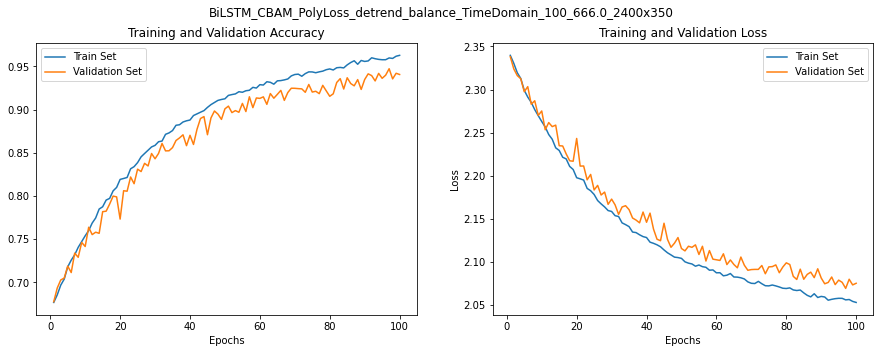

In [ ]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.suptitle(f"{model_name_str}")
plt.show()



In [ ]:
first_time_train_info=[acc,val_acc,loss,val_loss,epochs_range]
np.save(model_save_dir.joinpath(f"{model_name_str}_120history_result_1"), first_time_train_info)

# 测试 
## x_validate 中样本
- 计算各个类的 acc ,precision, recall, 混淆矩阵， ROC、PR 曲线

In [ ]:
from tensorflow.keras.models import load_model
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)
# model_name = model_name_str

# model_name="BiLSTM-2layerTimeDomain_100_666.0_2400x350_second.ckpt"
model_name = "BiLSTM_CBAM_detrend_balance_TimeDomain_150_666.0_2400x350"
# model_name = "BiLSTM_CBAM_PolyLoss_detrend_balance_TimeDomain_100_666.0_2400x350"
# model_name = "BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint"

# model_name = "TransformerEncoder-2layer_detrend_balance_TimeDomain_2000_666.0_2400x350_best_checkpoint"
# model_name = "BiGRU-12layer_detrend_balance_TimeDomain_130_666.0_2400x350_best_checkpoint"
# model_path=model_save_dir.joinpath(model_name)
# model = load_model(model_path)


validate set: X_TEST shape=(10813, 40, 60), Y_TEST shape=(10813, 1)
y_pred_result=[2.2327319e-04 1.2944474e-09 1.5356834e-06 2.7347582e-13 3.1117411e-12
 9.9974400e-01 3.1254691e-05], shape=(10000, 7)
Confusion Matrix=[[1457    5    1    0    4    3    7]
 [   1 1377    0    0    0    2    0]
 [   0    0 1532    0    0    3    7]
 [   0    1    0 1335   25    0    9]
 [   4    5    2   10 1342    3   23]
 [  17    2    2    3   10 1357   20]
 [   6    0   14    3   23   27 1358]]


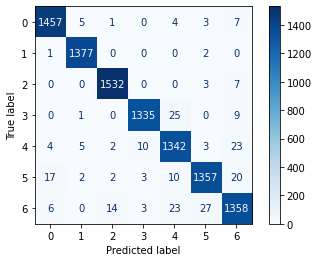

In [ ]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线

# TEST_DATA_NAME="test set"
# X_TEST_array=x_test  # x_validate
# Y_TEST_array=y_test  # y_validate
TEST_DATA_NAME="validate set"
X_TEST_array = x_validate
Y_TEST_array = y_validate
print(f"{TEST_DATA_NAME}: X_TEST shape={X_TEST_array.shape}, Y_TEST shape={Y_TEST_array.shape}")

test_num= min(10000,X_TEST_array.shape[0])
y_pred_score_result = model.predict(X_TEST_array[:test_num,])
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")
y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:test_num,],(test_num))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [ ]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.9758
Precision
class0's Precision=0.9811447811447811
class1's Precision=0.9906474820143885
class2's Precision=0.9877498388136686
class3's Precision=0.9881569207994079
class4's Precision=0.9558404558404558
class5's Precision=0.9727598566308244
class6's Precision=0.9536516853932584
Macro Precision= 0.9757072886623979
Recall
class0's Recall=0.98645903859174
class1's Recall=0.9978260869565218
class2's Recall=0.993514915693904
class3's Recall=0.9744525547445255
class4's Recall=0.9661627069834413
class5's Recall=0.9617292700212615
class6's Recall=0.9489867225716282
Macro Recall= 0.9755901850804317
F1-score
class0's F1-score=0.9837947332883187
class1's F1-score=0.9942238267148014
class2's F1-score=0.9906239896540575
class3's F1-score=0.9812568908489526
class4's F1-score=0.9609738632295023
class5's F1-score=0.9672131147540984
class6's F1-score=0.9513134851138353
Macro F1-score= 0.9756285576576523
Jaccard系数（分析相似度）
class0's Jaccard=0.9681063122923588
class1's Jaccard=0.98851399856424

[[0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]]
class_no=0:Area under the ROC curve: 0.9997743967476272
class_no=1:Area under the ROC curve: 0.99998764248966
class_no=2:Area under the ROC curve: 0.999885564101125
class_no=3:Area under the ROC curve: 0.9998244115333542
class_no=4:Area under the ROC curve: 0.9990307824497255
class_no=5:Area under the ROC curve: 0.9989111383794099
class_no=6:Area under the ROC curve: 0.9974730552878638
(1364,) (1364,) [0.         0.         0.         ... 0.95901667 0.95905    1.        ] [0.     0.2052 0.2746 ... 1.     1.     1.    ]
macro roc:Area under the ROC curve: 0.9974730552878638
class_no=0:Area under the PR curve: 0.998769451962872
class_no=1:Area under the PR curve: 0.9999231732307919
class_no=2:Area under the PR curve: 0.9993367487492169
class_no=3:Area under the PR curve: 0.9988926424421192
class_no=4:Area under the PR curve: 0.9939477627154742
class_no=5:Area under the PR curve: 0.9938962627825404
class_no=6:Area under the PR curve: 0.9

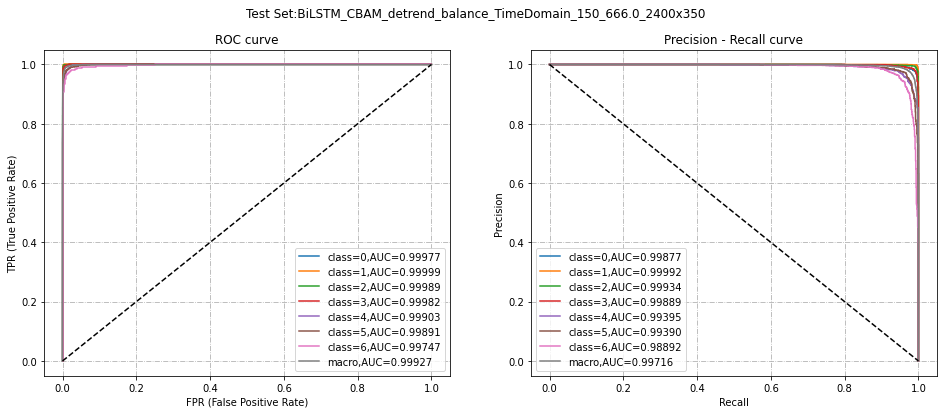

In [ ]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  # 绘制 macro-roc
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape, fpr_macro, tpr_macro)
  print (f"macro roc:Area under the ROC curve: {AUC_ROC}")
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")
  
  # 绘制 macro-pr
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


### Comparision: barely macro-ROC, macro-PR curve

[[0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]]
(1364,) (1364,)
class_no=macro:Area under the ROC curve: 0.9992695701412522
macro roc:Area under the PR curve: 0.997160645176373
保存 roc-pr 数据成功:save_path=/content/drive/MyDrive/Pulse_7_Classification/model/validate_roc_pr_BiLSTM_CBAM_detrend_balance_TimeDomain_150_666.0_2400x350


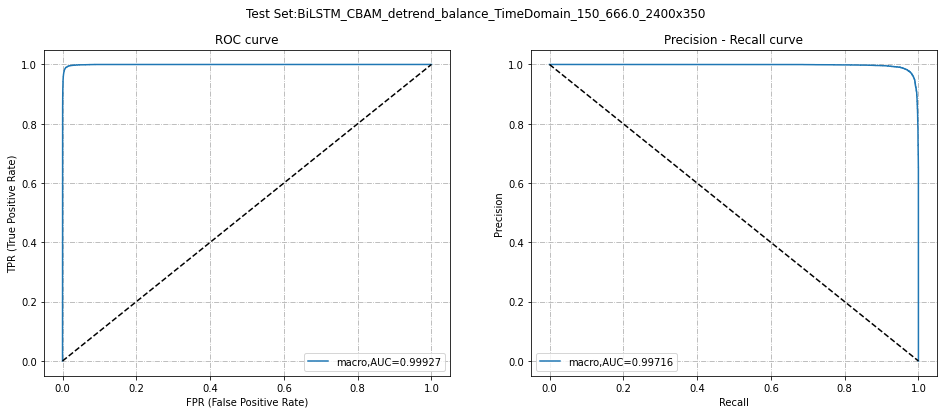

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_macro_roc_curve(y_true_one_hot,y_pred_scores):
  class_no='macro'
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape)
  print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC_macro}")
  plt.subplot(1,2,1)
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")

  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 绘制 macro-pr
  plt.subplot(1,2,2)
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")
  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 保存模型的 macro_fpr, macro_tpr, macro_recall, macro_precision
  save_path = model_save_dir.joinpath(f"validate_roc_pr_{model_name}").as_posix()
  data={"fpr":fpr_macro,"tpr": tpr_macro, "precision":precision_macro, "recall":recall_macro,
        "AUC_roc_macro":AUC_ROC_macro,"AUC_pr_macro":AUC_pr_macro_rec}
  np.savez(save_path,data=data)
  print(f"保存 roc-pr 数据成功:save_path={save_path}")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_macro_roc_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


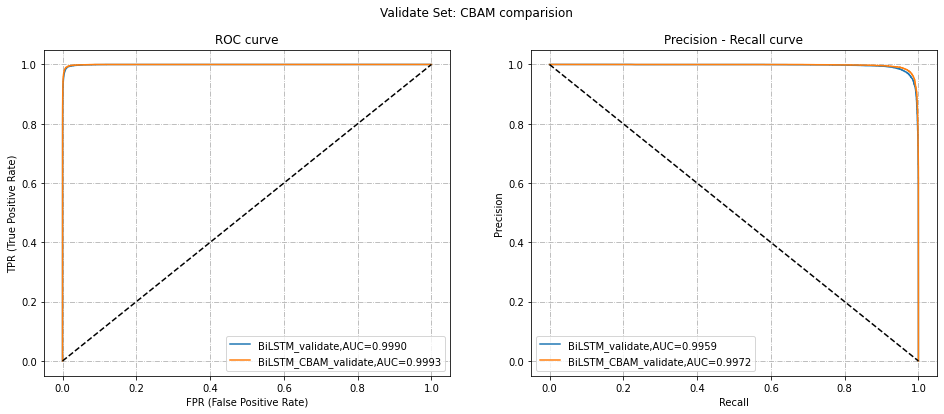

In [ ]:
# Inception10_result = np.load(model_save_dir.joinpath("roc_pr_Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
# Inception10_result = Inception10_result["data"].item()
VGG16_MFCC_no_detrend = np.load(model_save_dir.joinpath("roc_pr_VGG16_MFCC_130_666.0_840x280_130epoch.npz"), allow_pickle=True)
VGG16_MFCC_no_detrend = VGG16_MFCC_no_detrend["data"].item()
VGG_MFCC_detrend = np.load(model_save_dir.joinpath("roc_pr_VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint.npz"), allow_pickle=True)
VGG_MFCC_detrend = VGG_MFCC_detrend["data"].item()
BiLSTM_no_detrend = np.load(model_save_dir.joinpath("roc_pr_BiLSTM-2layerTimeDomain_100_666.0_2400x350_second.ckpt.npz"), allow_pickle=True)
BiLSTM_no_detrend = BiLSTM_no_detrend["data"].item()
BiLSTM_detrend = np.load(model_save_dir.joinpath("roc_pr_BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint.npz"), allow_pickle=True)
BiLSTM_detrend = BiLSTM_detrend["data"].item()

BiLSTM_validate = np.load(model_save_dir.joinpath("validate_roc_pr_BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint.npz"), allow_pickle=True)
BiLSTM_validate = BiLSTM_validate["data"].item()
BiLSTM_CBAM_validate = np.load(model_save_dir.joinpath("validate_roc_pr_BiLSTM_CBAM_detrend_balance_TimeDomain_150_666.0_2400x350.npz"), allow_pickle=True)
BiLSTM_CBAM_validate = BiLSTM_CBAM_validate["data"].item()
BiGRU_detrend = np.load(model_save_dir.joinpath("roc_pr_BiGRU-12layer_detrend_balance_TimeDomain_130_666.0_2400x350_best_checkpoint.npz"), allow_pickle=True)
BiGRU_detrend = BiGRU_detrend["data"].item()
Transformer_12layer_10head = np.load(model_save_dir.joinpath("roc_pr_TransformerEncoder-12layer10head_detrend_balance_TimeDomain_500_666.0_2400x350_best_checkpoint.npz"), allow_pickle=True)
Transformer_12layer_10head = Transformer_12layer_10head["data"].item()

plt.figure(figsize=(16,6))
plt.suptitle(f"Validate Set: CBAM comparision")
plt.subplot(1,2,1)
# plt.plot(VGG16_MFCC_no_detrend["fpr"],VGG16_MFCC_no_detrend["tpr"], label=f"VGG16_MFCC_no_detrend,AUC={VGG16_MFCC_no_detrend['AUC_roc_macro']:.4f}")
# plt.plot(VGG_MFCC_detrend["fpr"],VGG_MFCC_detrend["tpr"], label=f"VGG_MFCC_detrend,AUC={VGG_MFCC_detrend['AUC_roc_macro']:.4f}")
plt.plot(BiLSTM_validate["fpr"],BiLSTM_validate["tpr"], label=f"BiLSTM_validate,AUC={BiLSTM_validate['AUC_roc_macro']:.4f}")
# plt.plot(BiLSTM_no_detrend["fpr"],BiLSTM_no_detrend["tpr"], label=f"BiLSTM_no_detrend,AUC={BiLSTM_no_detrend['AUC_roc_macro']:.4f}")
plt.plot(BiLSTM_CBAM_validate["fpr"],BiLSTM_CBAM_validate["tpr"], label=f"BiLSTM_CBAM_validate,AUC={BiLSTM_CBAM_validate['AUC_roc_macro']:.4f}")
# plt.plot(BiGRU_detrend["fpr"],BiGRU_detrend["tpr"], label=f"BiGRU_detrend,AUC={BiGRU_detrend['AUC_roc_macro']:.4f}")
# plt.plot(Transformer_12layer_10head["fpr"],Transformer_12layer_10head["tpr"], label=f"Transformer_12layer_10head,AUC={Transformer_12layer_10head['AUC_roc_macro']:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.grid(which="major", axis='both', linestyle='-.')

plt.subplot(1,2,2)
# plt.plot(VGG16_MFCC_no_detrend["recall"],VGG16_MFCC_no_detrend["precision"], label=f"VGG16_MFCC_no_detrend,AUC={VGG16_MFCC_no_detrend['AUC_pr_macro']:.4f}")
# plt.plot(VGG_MFCC_detrend["recall"],VGG_MFCC_detrend["precision"], label=f"VGG_MFCC_detrend,AUC={VGG_MFCC_detrend['AUC_pr_macro']:.4f}")
plt.plot(BiLSTM_validate["recall"],BiLSTM_validate["precision"], label=f"BiLSTM_validate,AUC={BiLSTM_validate['AUC_pr_macro']:.4f}")
# plt.plot(BiLSTM_no_detrend["recall"],BiLSTM_no_detrend["precision"], label=f"BiLSTM_no_detrend,AUC={BiLSTM_no_detrend['AUC_pr_macro']:.4f}")
plt.plot(BiLSTM_CBAM_validate["recall"],BiLSTM_CBAM_validate["precision"], label=f"BiLSTM_CBAM_validate,AUC={BiLSTM_CBAM_validate['AUC_pr_macro']:.4f}")
# plt.plot(BiGRU_detrend["recall"],BiGRU_detrend["precision"], label=f"BiGRU_detrend,AUC={BiGRU_detrend['AUC_pr_macro']:.4f}")
# plt.plot(Transformer_12layer_10head["recall"],Transformer_12layer_10head["precision"], label=f"Transformer_12layer_10head,AUC={Transformer_12layer_10head['AUC_pr_macro']:.4f}")
plt.plot([0,1],[1,0],'k--')
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid(which="major", axis='both', linestyle='-.')

---
## 对完整样本给出预测结果

In [ ]:
pulse_preprocess = PulsePreprocessing()
pulse_feature = PulseFeature()

# 降采样数据
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time = time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time() - start_time}s")

# 测试数据: 取出完整样本预测
x_test = []
y_test = []
for class_no in pulse_all_class_data_dict:
    data_type = "test"
    for data_info_dict in pulse_all_class_data_dict[class_no][data_type]:
        x_test.append(data_info_dict["data"][0, :])
        y_test.append(class_no)
x_test_list = x_test  # 长度可能不一致！
y_test = np.array([y_test]).T

class_no=2 去基线漂移完成！
class_no=1 去基线漂移完成！
class_no=5 去基线漂移完成！
class_no=6 去基线漂移完成！
class_no=0 去基线漂移完成！
class_no=4 去基线漂移完成！
class_no=3 去基线漂移完成！
去噪+去基线漂移完成！costs=1.5674519538879395s


In [ ]:
print(f"x_test_list len={len(x_test_list)} y_test shape={y_test.shape}")
print(f"x_test[0] shape={x_test_list[0].shape}")

# 查看测试集合各类分布
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in pulse_all_class_data_dict}
print(f"y_test distribution:{train_distribution_dict}")

x_test_list len=35 y_test shape=(35, 1)
x_test[0] shape=(39960,)
y_test distribution:{2: 5, 1: 5, 5: 5, 6: 5, 0: 5, 4: 5, 3: 5}


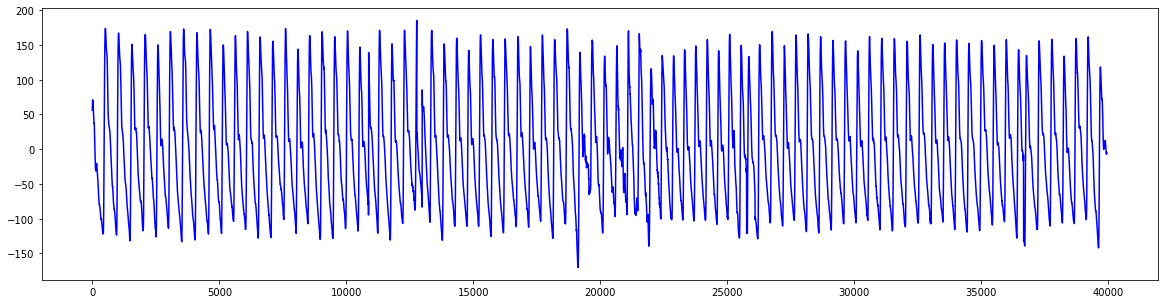

In [ ]:
def show_x_test_wave(wave_data):
  plt.figure(figsize=(20,5))
  plt.plot(wave_data[:],'b-')

  plt.show()
show_x_test_wave(wave_data=x_test_list[29])

### Two-stream model

In [ ]:
def two_stream_classifier(time_model, freq_model):
    time_model_input = Input(shape=(40, 60), name="time_model_input")
    freq_model_input = Input(shape=(None, None, 1), name="freq_model_input")
    time_result = time_model(time_model_input)
    freq_result = freq_model(freq_model_input)

    # two_stream_result = Add()([time_result, freq_result])  # two-stream late fusion
    # two_stream_result = freq_result  # frequency only
    two_stream_result = time_result

    network = Model(inputs=[time_model_input, freq_model_input], outputs=two_stream_result, name="two_stream_PulseNet")
    network = Model(inputs=[time_model_input, freq_model_input], outputs=two_stream_result, name="two_stream_PulseNet")
    return network


class TwoStreamPredict:
    def __init__(self, pulse_feature_instance: PulseFeature, freq_model: Model, time_model: Model,
                 feature_sample_rate=666, freq_frame_info=(840, 280), time_frame_info=(2400, 350, 40),
                 uniform_sample_num=10):
        self.pulse_feature = pulse_feature_instance
        self.sample_rate = feature_sample_rate
        self.uniform_sample_num = uniform_sample_num
        # 分片信息
        self.freq_frame_length = freq_frame_info[0]  # 频域模型使用的分片大小
        self.freq_frame_step = freq_frame_info[1]
        self.time_frame_length = time_frame_info[0]
        self.time_frame_step = time_frame_info[1]
        self.RNN_time_step = time_frame_info[2]
        assert self.time_frame_length % self.RNN_time_step == 0, f"RNN input shape error!"
        self.RNN_feature_num_each_input = int(self.time_frame_length / self.RNN_time_step)

        self.freq_model = freq_model
        self.time_model = time_model
        self.two_stream_model = two_stream_classifier(time_model=self.time_model, freq_model=self.freq_model)

    @staticmethod
    def get_data_slice(wave_data_array, frame_length, frame_step):
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 1, f"wave data shape error!"

        signal_length = len(wave_data_array)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(wave_data_array, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        return frames

    def batch_sample_predict(self, x_test_list: List[np.ndarray], numcep_mfcc=20) -> np.ndarray:
        """
        对每个原始样本预测
        :param x_test_list: 原始波形样本，长度可能不一致！
        :param numcep_mfcc:
        :return: y_sample_predict_score_result
        """
        assert len(x_test_list[0].shape) == 1, f"x_test_list element_array shape error!"
        y_sample_predict_result = []
        for index in range(len(x_test_list)):
            x_data = x_test_list[index]
            print(f"x_data shape={x_data.shape}")
            # 0. 时域分片 1x2400
            x_data_frames = self.get_data_slice(wave_data_array=x_data,
                                                frame_length=self.time_frame_length, frame_step=self.time_frame_step)

            # 均匀取 n 帧 进行预测
            select_index_array = np.linspace(0, x_data_frames.shape[0], self.uniform_sample_num,
                                             endpoint=False, dtype=int)
            select_slice_array = x_data_frames[select_index_array, :]
            # print(f"select_index_array={select_index_array}, select_slice_array shape={select_slice_array.shape}")

            # 1. 频域时域输入特征转化
            # 时域
            time_data_array = np.reshape(select_slice_array, (select_slice_array.shape[0],
                                                              self.RNN_time_step, self.RNN_feature_num_each_input))
            # 频域
            freq_data_array = []
            for wave_data in select_slice_array:
                wave_data = np.reshape(wave_data[:self.freq_frame_length], (1, self.freq_frame_length))
                mfcc_matrix = self.pulse_feature.get_dynamic_mfcc_matrix(wave_data=wave_data,
                                                                         sample_rate=self.sample_rate,
                                                                         numcep=numcep_mfcc)
                freq_data_array.append(mfcc_matrix)
            freq_data_array = np.array(freq_data_array)
            freq_data_array = np.reshape(freq_data_array, (*freq_data_array.shape, 1))
            # print(f"freq_data_array.shape={freq_data_array.shape}")

            # 2. 对每个分片预测
            # # 0. 单独调用方式
            # freq_predict_scores = self.freq_model.predict(freq_data_array)
            # time_predict_scores = self.time_model.predict(time_data_array)
            # y_slices_predict_scores = (freq_predict_scores + time_predict_scores) / 2

            # 1. 模型融合
            y_slices_predict_scores = self.two_stream_model.predict([time_data_array, freq_data_array])

            y_sample_predict_scores = np.average(y_slices_predict_scores, axis=0)
            y_sample_predict_result.append(y_sample_predict_scores)
            print(f"index={index} y_sample_predict_scores={y_sample_predict_scores} shape={y_sample_predict_scores.shape}")
            # break

        return np.array(y_sample_predict_result)




In [ ]:
# 对每个样本预测
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Add, Average, Maximum

model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)

# 0. 加载模型
time_model_name = "BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint"
freq_model_name = "VGG16_detrend_balance_MFCC_numcep20_666.0_840x280_best_checkpoint"  # "VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint"
time_model_path = model_save_dir.joinpath(time_model_name)
freq_model_path = model_save_dir.joinpath(freq_model_name)
assert time_model_path.exists() and freq_model_path.exists(), f"model file not exists"
time_domain_model = load_model(time_model_path)
freq_domain_model = load_model(freq_model_path)

# 1. 分片信息
_time_frame_info = (2400, 350, 40)  # frame_length, frame_step, RNN time step
_freq_frame_info = (840, 280)
assert _time_frame_info[0] % _time_frame_info[2] == 0, f"RNN input shape error!"
two_stream_predict = TwoStreamPredict(pulse_feature_instance=pulse_feature,
                                      freq_model=freq_domain_model, time_model=time_domain_model,
                                      feature_sample_rate=666, freq_frame_info=_freq_frame_info,
                                      time_frame_info=_time_frame_info,
                                      uniform_sample_num=10)
y_pred_score_result = two_stream_predict.batch_sample_predict(x_test_list=x_test_list)

test set: Y_TEST shape=(35, 1)
y_pred_result=[5.0459658e-07 2.2594117e-08 3.3590731e-01 2.5329500e-10 2.4026672e-08
 1.6400060e-01 5.0009155e-01], shape=(35, 7)
Confusion Matrix=[[4 0 0 0 0 1 0]
 [0 5 0 0 0 0 0]
 [0 0 1 0 0 0 4]
 [0 0 0 1 3 0 1]
 [0 0 0 0 5 0 0]
 [0 0 0 0 1 3 1]
 [0 0 0 0 1 1 3]]


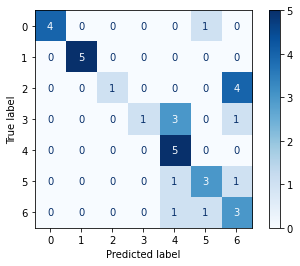

In [ ]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线
model_name = "Two-stream_MFCC&Time"
TEST_DATA_NAME="test set"
Y_TEST_array=y_test
print(f"{TEST_DATA_NAME}: Y_TEST shape={Y_TEST_array.shape}")
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")

y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:,],(Y_TEST_array.shape[0]))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [ ]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.6285714285714286
Precision
class0's Precision=1.0
class1's Precision=1.0
class2's Precision=1.0
class3's Precision=1.0
class4's Precision=0.5
class5's Precision=0.6
class6's Precision=0.3333333333333333
Macro Precision= 0.7761904761904761
Recall
class0's Recall=0.8
class1's Recall=1.0
class2's Recall=0.2
class3's Recall=0.2
class4's Recall=1.0
class5's Recall=0.6
class6's Recall=0.6
Macro Recall= 0.6285714285714287
F1-score
class0's F1-score=0.888888888888889
class1's F1-score=1.0
class2's F1-score=0.33333333333333337
class3's F1-score=0.33333333333333337
class4's F1-score=0.6666666666666666
class5's F1-score=0.6
class6's F1-score=0.42857142857142855
Macro F1-score= 0.6072562358276644
Jaccard系数（分析相似度）
class0's Jaccard=0.8
class1's Jaccard=1.0
class2's Jaccard=0.2
class3's Jaccard=0.2
class4's Jaccard=0.5
class5's Jaccard=0.42857142857142855
class6's Jaccard=0.2727272727272727
Macro Jaccard= 0.4858998144712431


[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
class_no=0:Area under the ROC curve: 0.9666666666666667
class_no=1:Area under the ROC curve: 0.7466666666666666
class_no=2:Area under the ROC curve: 0.9266666666666667
class_no=3:Area under the ROC curve: 0.8999999999999999
class_no=4:Area under the ROC curve: 0.8799999999999999
class_no=5:Area under the ROC curve: 0.39333333333333337
class_no=6:Area under the ROC curve: 0.41333333333333333
class_no=0:Area under the PR curve: 0.8605555555555555
class_no=1:Area under the PR curve: 0.22337024087024088
class_no=2:Area under the PR curve: 0.49777777777777776
class_no=3:Area under the PR curve: 0.4285064935064935
class_no=4:Area under the PR curve: 0.7222527472527472
class_no=5:Area under the PR curve: 0.13968338442603145
class_no=6:Area under the PR curve: 0.12016108568390516


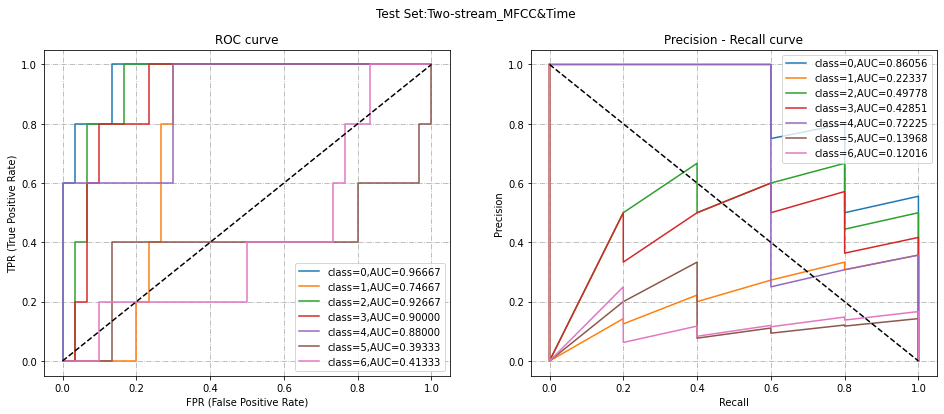

In [ ]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")



y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
